In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, datasets, models
from torchvision.io import read_image

from tempfile import TemporaryDirectory

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage import io

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [2]:
class AkuDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {
            "X": self.X[idx],
            "y": self.y[idx]
        }

        if self.transform:
            sample["X"] = self.transform(sample["X"])

        return sample

def loadAkuDataset(labels_file, root_dir, data_split=(0.7, 0.2, 0.1), transform = None):
    """
    @param labels_file: path to the csv file containing the labels for each image
    @param root_dir: path to the dir containing the original and augmented image folders
    @param data_split: three elements tuple containing the ratio of images for train, validation and test sets
    @param transform: a concatenation of trasformations to apply to the images
    @return a three element tuple containing the datasets for the training, validation and test sets
    """
    X = []
    y = []

    # read the labels from the csv file
    labels_df = pd.read_csv(labels_file)
    labels_df.set_index("Unnamed: 0", inplace=True)

    # reading the original images
    original_dir = f"{root_dir}/original"
    for filename in os.listdir(original_dir):
        path = f"{original_dir}/{filename}"
        X.append(Image.open(path))
        y.append(labels_df.loc[filename].values)

    # reading the augmented images
    augmented_dir = f"{root_dir}/augmented"
    for filename in os.listdir(augmented_dir):
        path = f"{augmented_dir}/{filename}"
        X.append( Image.open(path) )
        y.append(labels_df.loc[filename].values)

    # split the data in train, validation and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.1, random_state=42)

    return AkuDataset(X_train, y_train, transform), AkuDataset(X_val, y_val, transform), AkuDataset(X_test, y_test, transform)

In [3]:
labels_file = "./data/overall_labels.csv"
root_dir = "./data"
BATCH_SIZE = 4

# creating the datasets
train_dataset, val_dataset, test_dataset = loadAkuDataset(
    labels_file, 
    root_dir, 
    transform = transforms.Compose([
        transforms.Resize(400),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

# creating the data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', weights='IMAGENET1K_V1')

Using cache found in C:\Users\Ougi/.cache\torch\hub\pytorch_vision_v0.10.0


In [5]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
    dataloaders = {
        "train": train_dataloader,
        "val": val_dataloader
    }

    dataset_sizes = {
        x: len(dataloaders[x].sampler)
        for x in ["train", "val"]
    }
    
    # create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)
            
            for phase in ["train", "val"]: # for each epoch alternate between train and validation
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                    
                running_loss = 0.0
                running_corrects = 0
                           
                # iterate over data
                for sample in dataloaders[phase]:
                    inputs = sample["X"]
                    labels = sample["y"]
    
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
            
                    # forward
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        loss = criterion(outputs, labels)
                        if( phase == "train" ): # if training phase then backpropagate
                            loss.backward()
                            optimizer.step()
        
                    # compute statistics
                    running_loss += loss.item() * inputs.size(0)
                    
                    _ , top_labels = torch.max(labels, 1)
                    running_corrects += torch.sum(torch.eq(preds, top_labels))
                    #print("-"*5)
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
    
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model with best accuracy
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [6]:
N_EPOCHS = 10
LR = 0.001

# setting resnet layers as untrainable
for param in model.parameters():
    param.requires_grad = False

# adding a fresh new final layer to finetune
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 2), nn.Softmax(dim=None))
model = model.to(device)

# criterion to compute the loss
criterion = nn.CrossEntropyLoss()

# use sgd as optimizer
optimizer_ft = optim.SGD(model.parameters(), lr = LR)

# train the model
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer_ft, num_epochs=N_EPOCHS)

Epoch 0/9
----------


C:\Users\Ougi\PycharmProjects\CHL\.venv\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.4427, 0.5573],
        [0.5166, 0.4834],
        [0.5369, 0.4631],
        [0.5976, 0.4024]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.4611, 0.5389],
        [0.3966, 0.6034],
        [0.4960, 0.5040],
        [0.5370, 0.4630]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.4353, 0.5647],
        [0.5263, 0.4737],
        [0.4500, 0.5500],
        [0.6418, 0.3582]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3916, 0.6084],
        [0.5279, 0.4721],
        [0.5512, 0.4488],
        [0.4099, 0.5901]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.4673, 0.5327],
        [0.4674, 0.5326],
        [0.5173, 0.4827],
        [0.4209, 0.5791]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.4849, 0.5151],
        [0.3250, 0.6750],
        [0.5463, 0.4537],
        [0.5007, 0.4993]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.5047, 0.4953],
        [0.4759, 0.5241],
        [0.4520, 0.5480],
        [0.5552, 0.444

In [7]:
def imshow(inp, title=None):
    """
        Display image for Tensor.
        
        @param inp: tensor representing an image    
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloader, class_names, num_images=6):
    """
    Sample and plot a certain number of images from the dataset alongside
    the labels predicted by the model.
    
    @param model: the model used to make predictions
    @param dataloader: dataloader used to sample the images
    @param class_names: name of the classes predicted by the model
    @num_images: number of images shown
    """
    # save the status of the model and set it to eval mode
    was_training = model.training
    model.eval()
    
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for sample in dataloader: # iterate over batches of data
            inputs = sample["X"]
            labels = sample["y"]

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for  j in range(inputs.size()[0]): # unroll the batch
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                # check if we reached the number of images required
                if images_so_far == num_images: 
                    model.train(mode=was_training) # reset the previous state of the model
                    return
                    
        model.train(mode=was_training)

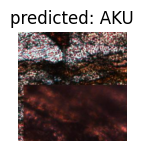

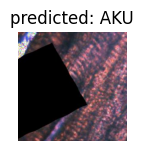

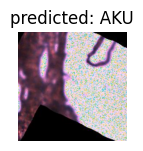

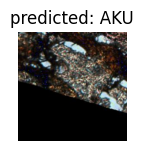

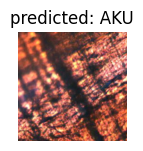

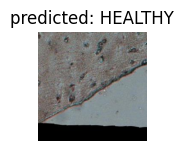

In [8]:
visualize_model(model, val_dataloader, ["HEALTHY", "AKU"])

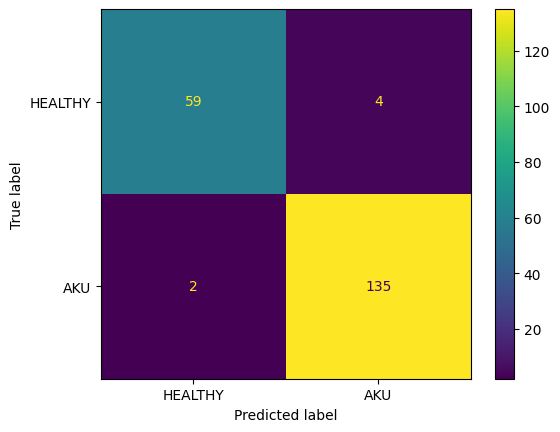

In [9]:
y_pred = [] # labels predicted by the model
y = [] # real labels


# iterate over all the validation data
for sample in val_dataloader:
    inputs = sample["X"].cuda()
    labels = sample["y"].cuda()

    outputs = model(inputs)

    for _ in torch.max(outputs, 1).indices:
        y_pred.append(_.item())

    for _ in torch.max(labels, 1).indices:
        y.append(_.item())
        
cm = confusion_matrix(y, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HEALTHY", "AKU"])
disp.plot()